In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler as StandardScaler

This notebook deals with used car prices, based on the kaggle car price prediction challeng dataset.
The target is to investigate how prices are affected by their different features to help potential car buyers to make informed decisions.

In [2]:
%%capture
# necessary, if model is used the way described on Udacity
'''# import warnings filter (for irgnoring future warning for normalization in sklearn model)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)'''

In [3]:
# load dataset, dataset origin: https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge
df= pd.read_csv('/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv')

# Inspect and Clean Dataset

In [4]:
df.shape

(19237, 18)

In [5]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [6]:
# remove duplicate rows, if any
df = df.drop_duplicates()
df.shape

(18924, 18)

In [7]:
df.shape

(18924, 18)

In [8]:
df.isnull().any()

ID                  False
Price               False
Levy                False
Manufacturer        False
Model               False
Prod. year          False
Category            False
Leather interior    False
Fuel type           False
Engine volume       False
Mileage             False
Cylinders           False
Gear box type       False
Drive wheels        False
Doors               False
Wheel               False
Color               False
Airbags             False
dtype: bool

In [9]:
# no NaNs, let's look at the dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  object 
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  object 
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  object 
 10  Mileage           18924 non-null  object 
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Doors             18924 non-null  object 
 15  Wheel             18924 non-null  object 
 16  Color             18924 non-null  object

In [10]:
# 1) Columns Levy, Engine volume and Mileage would be expected to be numeric -> search for non-numeric values
# 2) Doors: dates need to be replaced with plausible values (using value counts, dates were found)

In [11]:
# as could be seen by the .head(), some entries in Levy are '-', which we will interpret as 0
df['Levy'] = df['Levy'].replace('-', 0)
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')

In [12]:
# look into 'Engine volume', which is of dtype 'object' when float ist expected
df['Engine volume']

0              3.5
1                3
2              1.3
3              2.5
4              1.3
           ...    
19232    2.0 Turbo
19233          2.4
19234            2
19235            2
19236          2.4
Name: Engine volume, Length: 18924, dtype: object

In [13]:
# because of the string ' Turbo' this column is not numeric. Instead of just removing the string, we add a new column to encode
# this information as a categorical variable before removing it from column 'Engine volume'
df['Turbo'] = ['turbo' if 'Turbo' in x else 'no turbo' for x in df['Engine volume']]
df['Engine volume'] = df['Engine volume'].replace(' Turbo', '', regex=True)
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')  # coerce will put NaNs where not able to convert
df['Engine volume'].isnull().any()  # check, if conversion to numeric column worked or if there are more strings to take care of

False

In [14]:
# clean Mileage column, as ' km' was present in the cells displayed with .head()
df['Mileage'] = df['Mileage'].replace(' km', '', regex=True)
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')  # coerce will put NaNs where not able to convert
df['Mileage'].isnull().any()  # check, if conversion to numeric column worked or if there are more strings to take care of

False

In [15]:
df['Doors'].value_counts()

04-May    18032
02-Mar      768
>5          124
Name: Doors, dtype: int64

In [16]:
# there are 3 values, 2 of which are interpreted as dates. 
# 02-Mar is most likely 2-3, 04-May is most likely 4-5, >5 makes sense
df.loc[df['Doors'] == '04-May', 'Doors'] = '4-5'
df.loc[df['Doors'] == '02-Mar', 'Doors'] = '2-3'
df['Doors'].value_counts()

4-5    18032
2-3      768
>5       124
Name: Doors, dtype: int64

In [17]:
# replace production year with age of car instead, by year of publication - prodYear (no publication date found, 2021 is assumed)
df['Age'] = 2021 - df['Prod. year']
df['Age']

0        11
1        10
2        15
3        10
4         7
         ..
19232    22
19233    10
19234    11
19235    14
19236     9
Name: Age, Length: 18924, dtype: int64

In [18]:
df = df.drop(['ID', 'Prod. year'], axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18924 non-null  int64  
 1   Levy              18924 non-null  int64  
 2   Manufacturer      18924 non-null  object 
 3   Model             18924 non-null  object 
 4   Category          18924 non-null  object 
 5   Leather interior  18924 non-null  object 
 6   Fuel type         18924 non-null  object 
 7   Engine volume     18924 non-null  float64
 8   Mileage           18924 non-null  int64  
 9   Cylinders         18924 non-null  float64
 10  Gear box type     18924 non-null  object 
 11  Drive wheels      18924 non-null  object 
 12  Doors             18924 non-null  object 
 13  Wheel             18924 non-null  object 
 14  Color             18924 non-null  object 
 15  Airbags           18924 non-null  int64  
 16  Turbo             18924 non-null  object

In [20]:
df.describe(())

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,Age
count,1.892400e+04,18924.000000,18924.000000,1.892400e+04,18924.000000,18924.000000,18924.000000
mean,1.858744e+04,632.886493,2.306251,1.555373e+06,4.580216,6.568379,10.085764
std,1.921356e+05,568.273736,0.877591,4.880221e+07,1.200223,4.322323,5.665749
min,1.000000e+00,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000
50%,1.317200e+04,642.000000,2.000000,1.264000e+05,4.000000,6.000000,9.000000
max,2.630750e+07,11714.000000,20.000000,2.147484e+09,16.000000,16.000000,82.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Levy'}>,
        <AxesSubplot:title={'center':'Engine volume'}>],
       [<AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Cylinders'}>,
        <AxesSubplot:title={'center':'Airbags'}>],
       [<AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

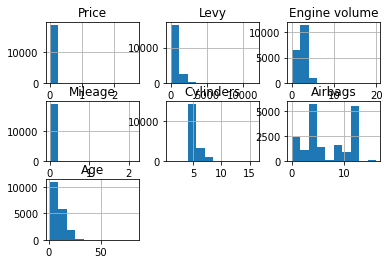

In [21]:
df.hist()

In [22]:
df['Category'].value_counts()

Sedan          8600
Jeep           5378
Hatchback      2799
Minivan         633
Coupe           528
Universal       361
Microbus        299
Goods wagon     229
Pickup           51
Cabriolet        35
Limousine        11
Name: Category, dtype: int64

In [23]:
df = df.drop(df[df['Category'] == 'Goods wagon'].index)  # remove goods wagons as we are only interested in passenger cars

In [24]:
df['Color'].value_counts()

Black            4930
White            4311
Silver           3696
Grey             2334
Blue             1336
Red               607
Green             311
Orange            249
Brown             184
Carnelian red     174
Golden            143
Beige             132
Sky blue          121
Yellow            103
Purple             39
Pink               25
Name: Color, dtype: int64

In [25]:
# merge 'Red' and 'Carnelian red'; merge 'Blue' and 'Sky blue'
df.loc[df['Color'] == 'Carnelian red', 'Color'] = 'Red'
df.loc[df['Color'] == 'Sky blue', 'Color'] = 'Blue'

In [26]:
df['Fuel type'].value_counts()

Petrol            9897
Diesel            3839
Hybrid            3539
LPG                882
CNG                452
Plug-in Hybrid      85
Hydrogen             1
Name: Fuel type, dtype: int64

In [27]:
# there is only 1 hydrogen car. To avoid outliers, we remove this one car
df = df.drop(df[df['Fuel type'] == 'Hydrogen'].index)

In [28]:
df.sort_values(by='Engine volume', ascending=False)

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age
17777,10036,5603,HYUNDAI,Sonata,Sedan,Yes,LPG,20.0,333686,4.0,Automatic,Front,4-5,Left wheel,Silver,4,no turbo,7
2357,10036,5603,HYUNDAI,Sonata,Sedan,Yes,LPG,20.0,333686,4.0,Automatic,Front,4-5,Left wheel,Silver,4,no turbo,7
5367,7840,5877,MERCEDES-BENZ,CLK 430,Cabriolet,No,Petrol,7.3,156470,12.0,Automatic,Rear,4-5,Left wheel,Black,12,no turbo,16
4722,175622,2819,BENTLEY,Mulsanne,Sedan,Yes,Petrol,6.8,6189,8.0,Automatic,Rear,4-5,Left wheel,Black,12,no turbo,5
1086,1019,1935,DODGE,RAM,Pickup,Yes,Diesel,6.7,367053,6.0,Automatic,Front,4-5,Left wheel,White,12,no turbo,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4814,17663,87,TOYOTA,Aqua,Hatchback,Yes,Petrol,0.0,118000,4.0,Automatic,Front,4-5,Left wheel,Grey,4,no turbo,9
2010,53941,87,TESLA,Model X,Sedan,Yes,Petrol,0.0,81907,6.0,Automatic,4x4,4-5,Left wheel,Silver,12,no turbo,3
14642,3,87,PORSCHE,Panamera,Sedan,Yes,Petrol,0.0,196800,6.0,Automatic,Rear,4-5,Left wheel,Black,12,no turbo,10
7685,47076,87,SSANGYONG,REXTON,Jeep,Yes,Diesel,0.0,73968,4.0,Automatic,Front,4-5,Left wheel,Black,4,no turbo,5


In [29]:
df[df['Engine volume'] == 0].count()
# outliers with engine volumes of 20 liters and 0 liters are dropped
df = df.drop(df[df['Engine volume'] == 20].index)
df = df.drop(df[df['Engine volume'] == 0].index)

In [30]:
df[df['Cylinders'] > 10].sort_values(by='Cylinders', ascending=False)

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age
1917,7000,0,HONDA,Fit Aria,Hatchback,No,Petrol,1.5,140203,16.0,Automatic,Front,4-5,Right-hand drive,Silver,2,turbo,18
6863,21953,0,HYUNDAI,Elantra,Sedan,Yes,Petrol,1.8,69000,16.0,Automatic,Front,4-5,Left wheel,Silver,16,no turbo,5
12550,39829,0,BMW,X6,Jeep,Yes,Petrol,3.5,152000,16.0,Tiptronic,4x4,4-5,Left wheel,Grey,16,turbo,12
8358,15681,966,CHEVROLET,Lacetti,Sedan,Yes,Diesel,2.0,6500,14.0,Automatic,Front,4-5,Left wheel,White,8,no turbo,12
115,11917,11714,MERCEDES-BENZ,E 500 AMG,Sedan,Yes,Petrol,5.0,150000,12.0,Tiptronic,Rear,4-5,Right-hand drive,White,12,no turbo,18
14096,42337,639,BMW,528,Sedan,Yes,Petrol,2.0,10000,12.0,Automatic,Rear,4-5,Left wheel,White,12,turbo,7
10640,16308,751,KIA,Optima EX,Sedan,Yes,Petrol,2.4,92000,12.0,Tiptronic,Front,4-5,Left wheel,Silver,8,no turbo,8
10837,27598,639,VOLKSWAGEN,Tiguan,Jeep,Yes,Petrol,2.0,113000,12.0,Tiptronic,4x4,4-5,Left wheel,White,12,turbo,7
10934,65545,1079,MERCEDES-BENZ,GLC 300,Jeep,Yes,Petrol,2.0,12000,12.0,Tiptronic,Rear,4-5,Left wheel,Black,12,turbo,3
11860,14113,2874,FORD,Explorer XLT,Jeep,Yes,Petrol,4.0,117000,12.0,Automatic,4x4,4-5,Left wheel,Grey,12,no turbo,15


In [31]:
# from the histogram it can be seen that there are cars with 16 cylinders. This is worth having a closer look.
# Thus it was found quite an amount of cars with > 10 cylinders are not plausible. 
# e.g. hatchbacks or Honda or Kia sedans are not plausible. Engine volumes, which are technically closely related to cylinder
# count, however, look mostly plausible after having removed the outliers.
# we will thus use this as a proxy to calculate more plausible cylinder numbers: 
# often cylinder volumes are in the order of about 0.5 litres

df['Vol per cylinder'] = df['Engine volume'] / df['Cylinders']
df[df['Vol per cylinder'] > 0.75]['Price'].count()  # we will take 0.75 as the threshold for the date we clean (0.5 plus 50%)
df[df['Vol per cylinder'] == 0]['Price'].count()  # we will also replace 0 cylinders accordingly as there are only cars with ICE left in the dataset

0

In [32]:
# the 222 vehicles found above, we will calculate a plausible cylinder number based on the engine volume and round to full cylinders
df_cyl_clean = df[df['Vol per cylinder'] > 0.75].copy()
df_cyl_clean = pd.concat([df_cyl_clean, df[df['Vol per cylinder'] == 0]])
df = df.drop(df[df['Vol per cylinder'] > 0.75].index)
df = df.drop(df[df['Vol per cylinder'] == 0].index)
df_cyl_clean['Cylinders'] = np.ceil(df_cyl_clean['Engine volume'].div(0.5).div(2)).mul(2)  # ceil(num / 2) * 2 to round to closest even number as cylinder numbers are far more often even than odd 
df = pd.concat([df, df_cyl_clean])
df = df.drop(['Vol per cylinder'], axis=1)
df

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age
0,13328,1399,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,4-5,Left wheel,Silver,12,no turbo,11
1,16621,1018,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,4-5,Left wheel,Black,8,no turbo,10
2,8467,0,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,4-5,Right-hand drive,Black,2,no turbo,15
3,3607,862,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,4-5,Left wheel,White,0,no turbo,10
4,11726,446,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,4-5,Left wheel,Silver,4,no turbo,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18989,26701,1055,FORD,Taurus,Sedan,Yes,Petrol,3.5,110439,8.0,Automatic,Front,4-5,Left wheel,Red,4,no turbo,8
19041,3200,0,GAZ,20,Jeep,No,Petrol,3.2,100000,8.0,Manual,4x4,2-3,Left wheel,Green,0,no turbo,68
19074,40424,1493,FORD,Explorer,Minivan,Yes,Petrol,3.5,97000,8.0,Automatic,Front,4-5,Left wheel,Grey,4,no turbo,5
19109,58332,1055,LEXUS,RX 350,Jeep,Yes,Petrol,3.5,165581,8.0,Automatic,Front,4-5,Left wheel,Silver,4,no turbo,8


In [33]:
# For 'Mileage' std is an order of magnitude higher than the mean. the max looks rather unplausible as well.
# restrict our dataset to the 99,5% quantile to remove outliers
#df['Mileage'].hist()
df = df[df['Mileage'] <= df['Mileage'].quantile(0.995)]
df.describe()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,Age
count,18588.000000,18588.000000,18588.000000,18588.000000,18588.000000,18588.000000,18588.000000
mean,17325.110717,638.299978,2.311481,138809.188993,4.636217,6.617065,9.956800
std,19922.494128,564.553876,0.860307,99229.575222,1.283760,4.325279,5.568186
min,1.000000,0.000000,0.100000,0.000000,1.000000,0.000000,1.000000
25%,5331.000000,0.000000,1.800000,70000.000000,4.000000,4.000000,6.000000
50%,13172.000000,645.000000,2.000000,125000.000000,4.000000,6.000000,9.000000
75%,22502.000000,917.000000,2.500000,187000.000000,5.000000,12.000000,12.000000
max,872946.000000,11714.000000,7.300000,746740.000000,16.000000,16.000000,82.000000


In [34]:
df[df['Mileage'] <100]

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age
11,8781,0,FORD,Transit,Microbus,No,CNG,4.0,0,8.0,Manual,Rear,2-3,Left wheel,Blue,0,no turbo,22
24,4704,0,OPEL,Vectra,Sedan,No,Petrol,1.8,0,4.0,Automatic,Front,4-5,Left wheel,Green,4,no turbo,26
26,549,2455,LEXUS,GX 470,Jeep,Yes,Petrol,4.7,0,8.0,Automatic,4x4,4-5,Left wheel,White,0,no turbo,13
83,8154,0,HONDA,Cr-v,Jeep,No,Petrol,2.0,0,4.0,Automatic,4x4,4-5,Right-hand drive,White,2,no turbo,23
97,4234,0,HONDA,Civic,Hatchback,Yes,Petrol,1.4,0,4.0,Manual,Front,2-3,Left wheel,Blue,6,no turbo,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9242,5645,0,VOLKSWAGEN,Jetta,Sedan,No,Petrol,2.0,0,4.0,Manual,Front,4-5,Left wheel,Black,2,no turbo,24
13104,18189,0,HYUNDAI,Sonata,Sedan,Yes,Petrol,2.4,0,6.0,Tiptronic,Rear,4-5,Left wheel,Silver,12,no turbo,10
14808,5331,0,FORD,Galaxy,Minivan,No,Diesel,1.8,0,4.0,Manual,Rear,4-5,Left wheel,White,0,no turbo,22
17647,1700,0,VAZ,2106,Sedan,No,Petrol,1.6,0,4.0,Manual,Front,4-5,Left wheel,Black,2,no turbo,33


In [35]:
# Many cars with Mileage of 0 even after several years. We will replace the 0 with the product of their age and the
# mean mileage for all cars which are older than 3 years
mean_mileage_per_year = round(df['Mileage'].mean() / df['Age'].mean())
mean_mileage_per_year

13941

In [36]:
cond = (df['Mileage'] < 100) & (df['Age'] > 3)
df.loc[cond, 'Mileage'] = df['Age'] * mean_mileage_per_year
df['Mileage'].describe()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


count     18588.000000
mean     145929.688993
std       98343.693957
min           0.000000
25%       77459.500000
50%      130000.000000
75%      192000.000000
max      947988.000000
Name: Mileage, dtype: float64

# Analysis

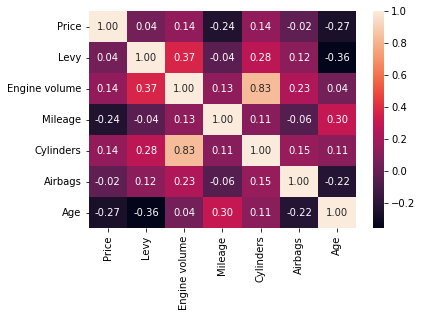

In [37]:
# correlation matrix for numeric colums only
sns.heatmap(df.corr(), annot=True, fmt=".2f");

In [38]:
# above correlation matrix confirms the commonly known fact that prices for ordinary cars usually decline with the age of a car.
# thus the next few evaluations build on this knowledge

In [39]:
cars_per_year = df.groupby('Age').count()['Price']
cars_per_year

Age
1       47
2      304
3      489
4      941
5     1443
6     1526
7     2081
8     1906
9     2120
10    1567
11    1449
12     577
13     712
14     441
15     304
16     377
17     332
18     329
19     272
20     239
21     260
22     188
23     181
24     135
25      97
26      91
27      39
28      23
29      29
30       8
31      18
32       6
33      12
34       5
35       6
36       3
37       4
38       3
39       1
40       1
41       2
43       1
44       2
45       1
47       1
48       1
56       2
57       2
64       1
68       4
74       1
78       1
82       3
Name: Price, dtype: int64

In [40]:
df.groupby('Age').mean().astype(int)['Price']

Age
1      63006
2      30746
3      35420
4      26999
5      28353
6      20926
7      17950
8      16694
9      15338
10     14040
11     14287
12     13652
13     11367
14     13135
15     12964
16     10961
17     11388
18      9906
19      9275
20      8659
21      8180
22      7743
23      7355
24      6464
25      6456
26      6469
27      6049
28      6407
29      5748
30      4871
31      5215
32      3546
33      4849
34      8828
35      4906
36      3244
37      3881
38      1300
39     31361
40      2800
41      1925
43      1300
44     10340
45       400
47      2437
48     15681
56     65074
57      6585
64      7527
68     17735
74       150
78    119172
82       171
Name: Price, dtype: int64

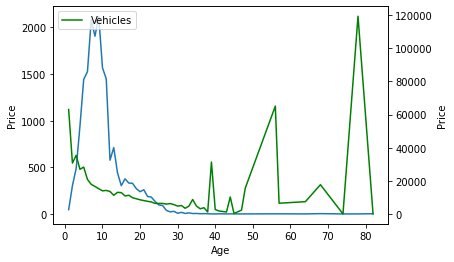

In [41]:
ax = sns.lineplot(data=cars_per_year, ci=None)
ax2=ax.twinx()
sns.lineplot(x='Age', y='Price', data=df, ax=ax2, color='g', ci=None)
ax.xlabel='Age'
ax.ylabel='Vehicles'
ax2.ylabel='Price'
plt.legend(labels=['Vehicles', 'Mean Price per Vehicle'])

<AxesSubplot:xlabel='Age', ylabel='Price'>

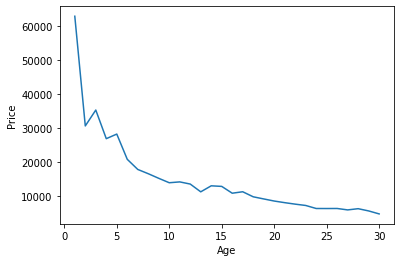

In [42]:
# we will restrict our analysis to cars <30 years. Cars older than 30 years are hardly relevant for the average buyer and 
# vintage car prices would be worth a separate analysis (which this dataset is not suited for)
# thus we also remove the peaks of of mean prices after 30+ years, caused by outliers of too few cars in the dataset for these ranges.
df = df[df['Age'] <=30]  # remove cars <30 years for the reasons mentioned above
sns.lineplot(x='Age', y='Price', data=df, ci=None)

In [43]:
df = df[df['Price'] <= df['Price'].quantile(0.99)]  # eliminate outliers (excessively expensive cars) to focus on the main market
df = df[df['Price'] >= df['Price'].quantile(0.01)]  # eliminate outliers (excessively cheap cars) to focus on the main market

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Levy'}>,
        <AxesSubplot:title={'center':'Engine volume'}>],
       [<AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Cylinders'}>,
        <AxesSubplot:title={'center':'Airbags'}>],
       [<AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

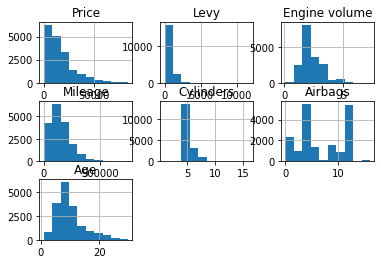

In [44]:
df.hist()

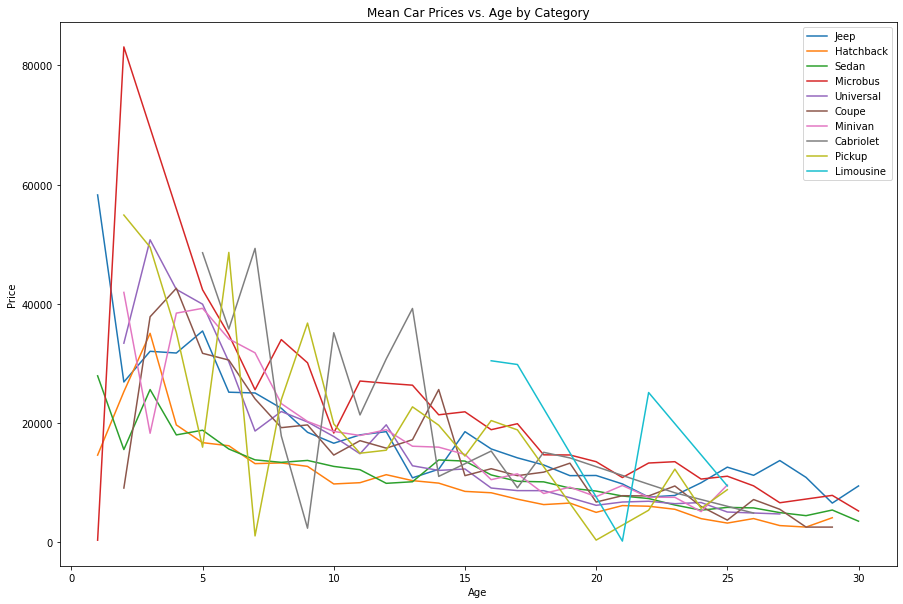

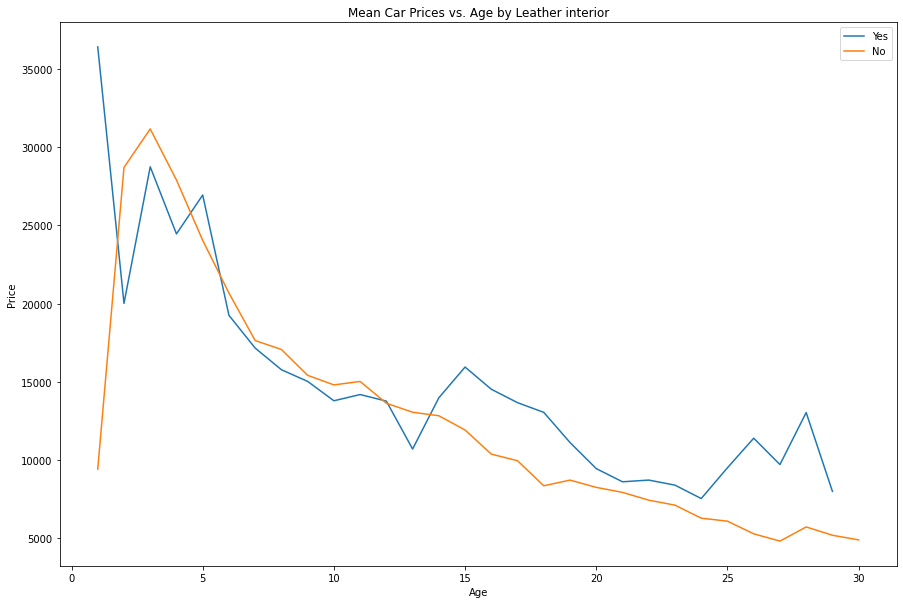

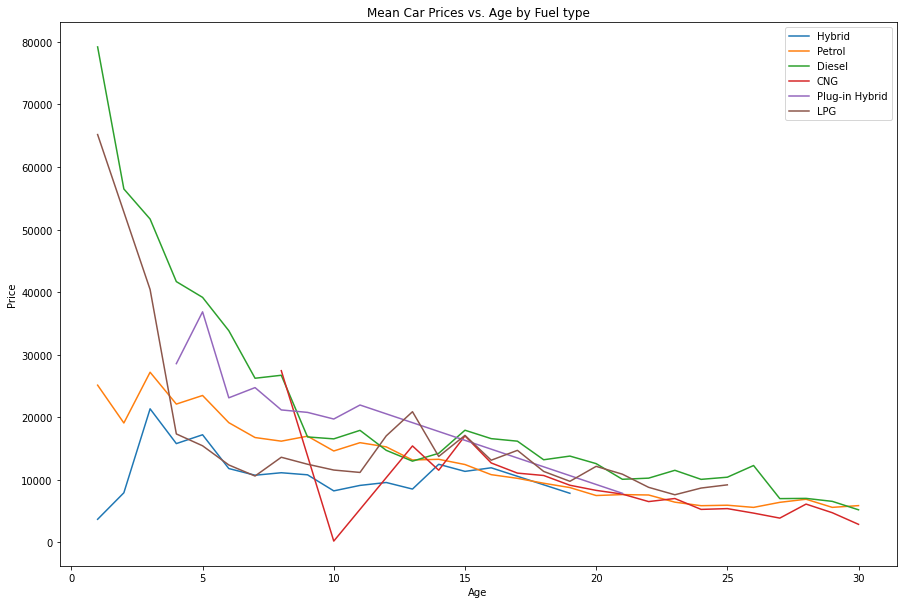

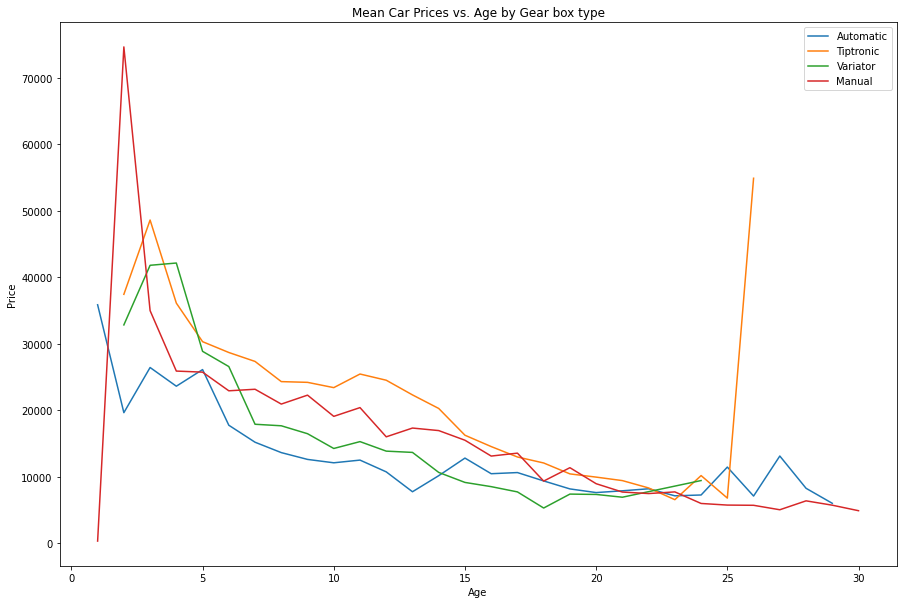

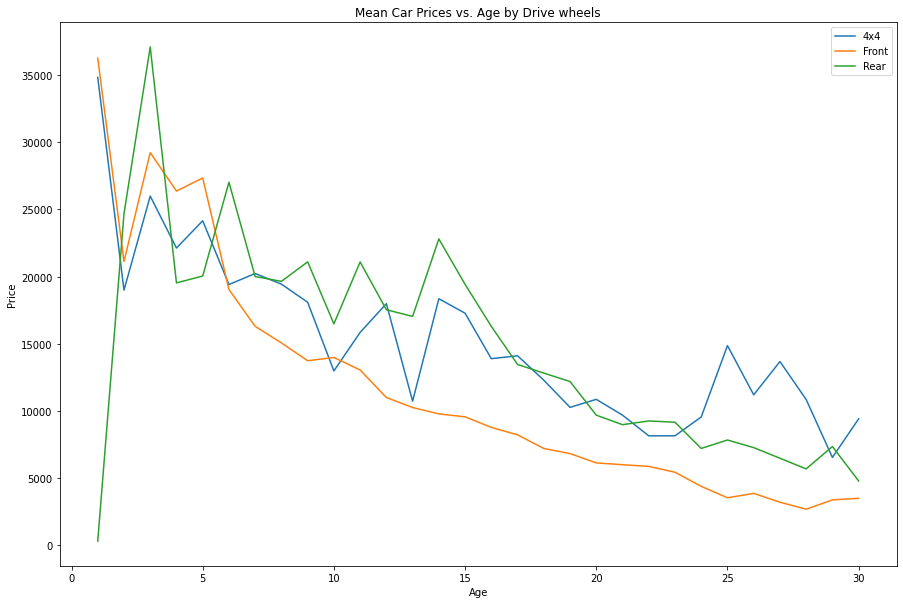

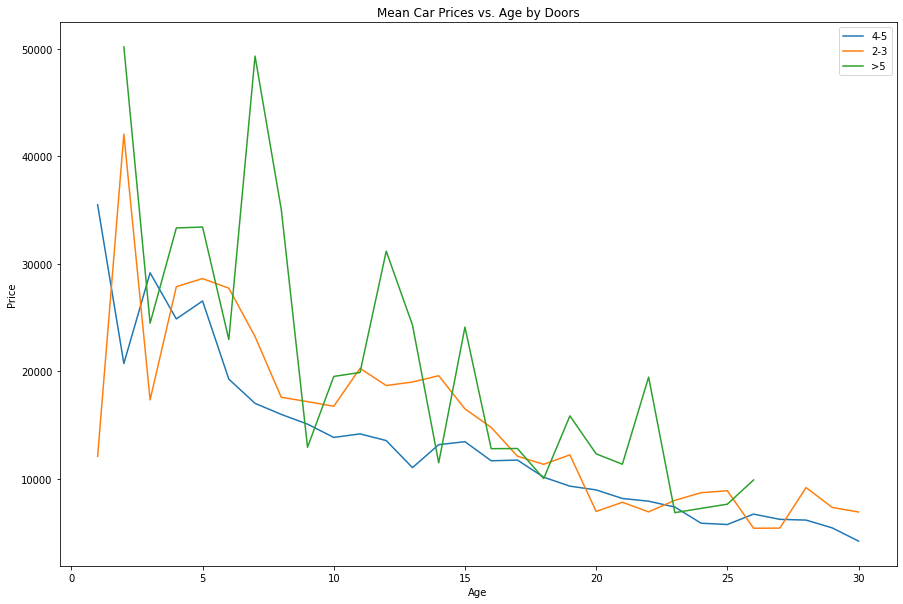

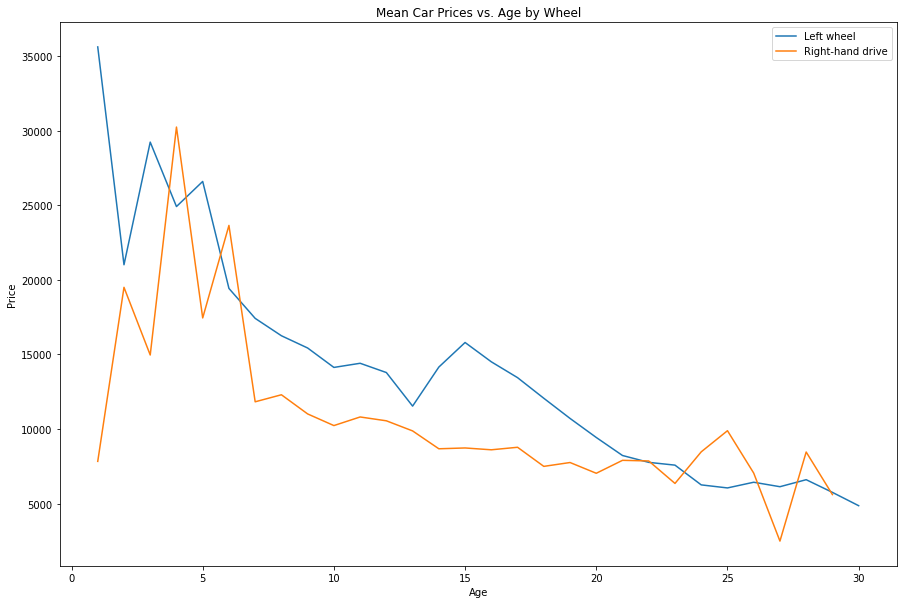

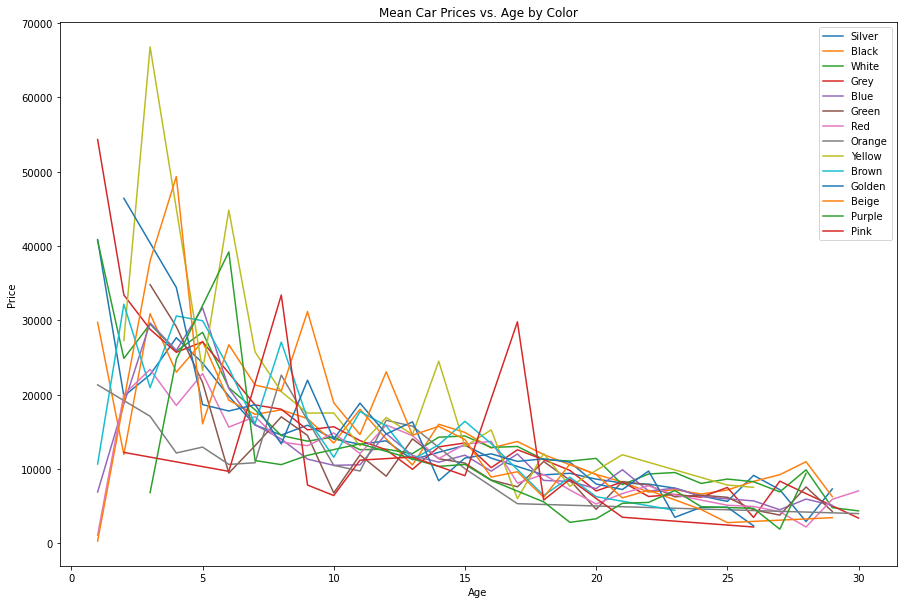

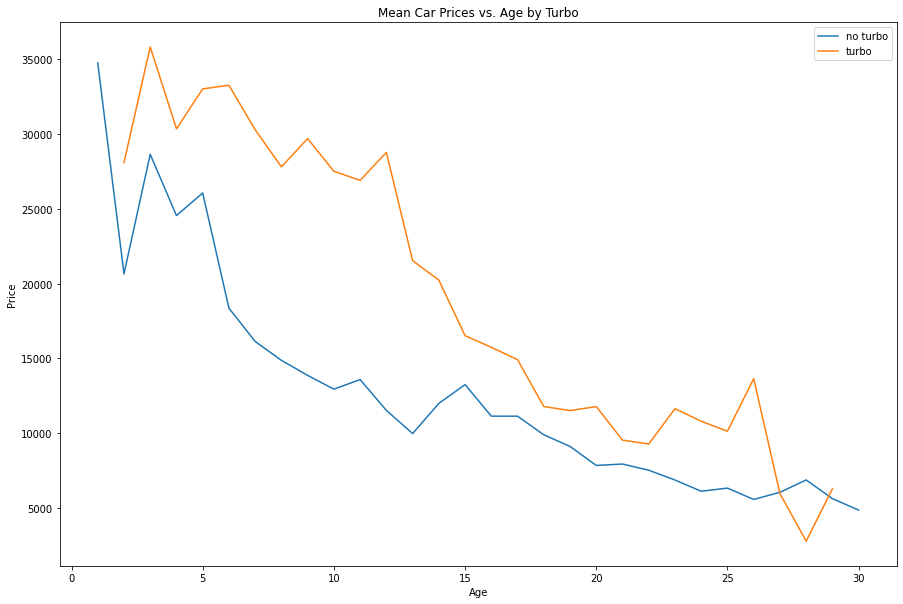

In [45]:
col_names = df.columns.to_list()
for col in df.select_dtypes(exclude=['object']).columns.to_list():
    col_names.remove(col)
col_names.remove('Manufacturer')
col_names.remove('Model')


def plot_price_age_per_column (df: pd.DataFrame, col_names: List[str]) -> None:
    """ Plot one chart of price vs age per column with column values as series
    
    Args:
        df: dataframe
        col_names: list of names of columns to plot
        
    Returns:
        plots of price vs age per column with column values as series
    
    """
    for col in col_names:
        plt.figure(figsize=(15, 10))
        series = df[col].unique().tolist()
        for entry in series:
            sns.lineplot(x='Age', y='Price', data=df[df[col] == entry], ci=None)
        plt.title(label='Mean Car Prices vs. Age by ' + col)
        plt.legend(labels=series)
        
plot_price_age_per_column(df, col_names)

# Modeling, Correlations and Predicting Prices

In [46]:
# encode numerical variables
# remove 'Manufacturer' and 'Model' since dataset is too small to be able to generalize and would overfit
df_cat = df.select_dtypes(include=['object']).copy()
df_cat = df_cat.drop('Model', axis=1)  # remove column Model to not drastically overfit
df_cat = df_cat.drop('Manufacturer', axis=1)  # remove column Manufacturer to not drastically overfit
df_cat = pd.get_dummies(df_cat, drop_first=True)
df = df.drop(df.select_dtypes(include=['object']).columns, axis=1)
df = pd.concat([df, df_cat], axis=1)

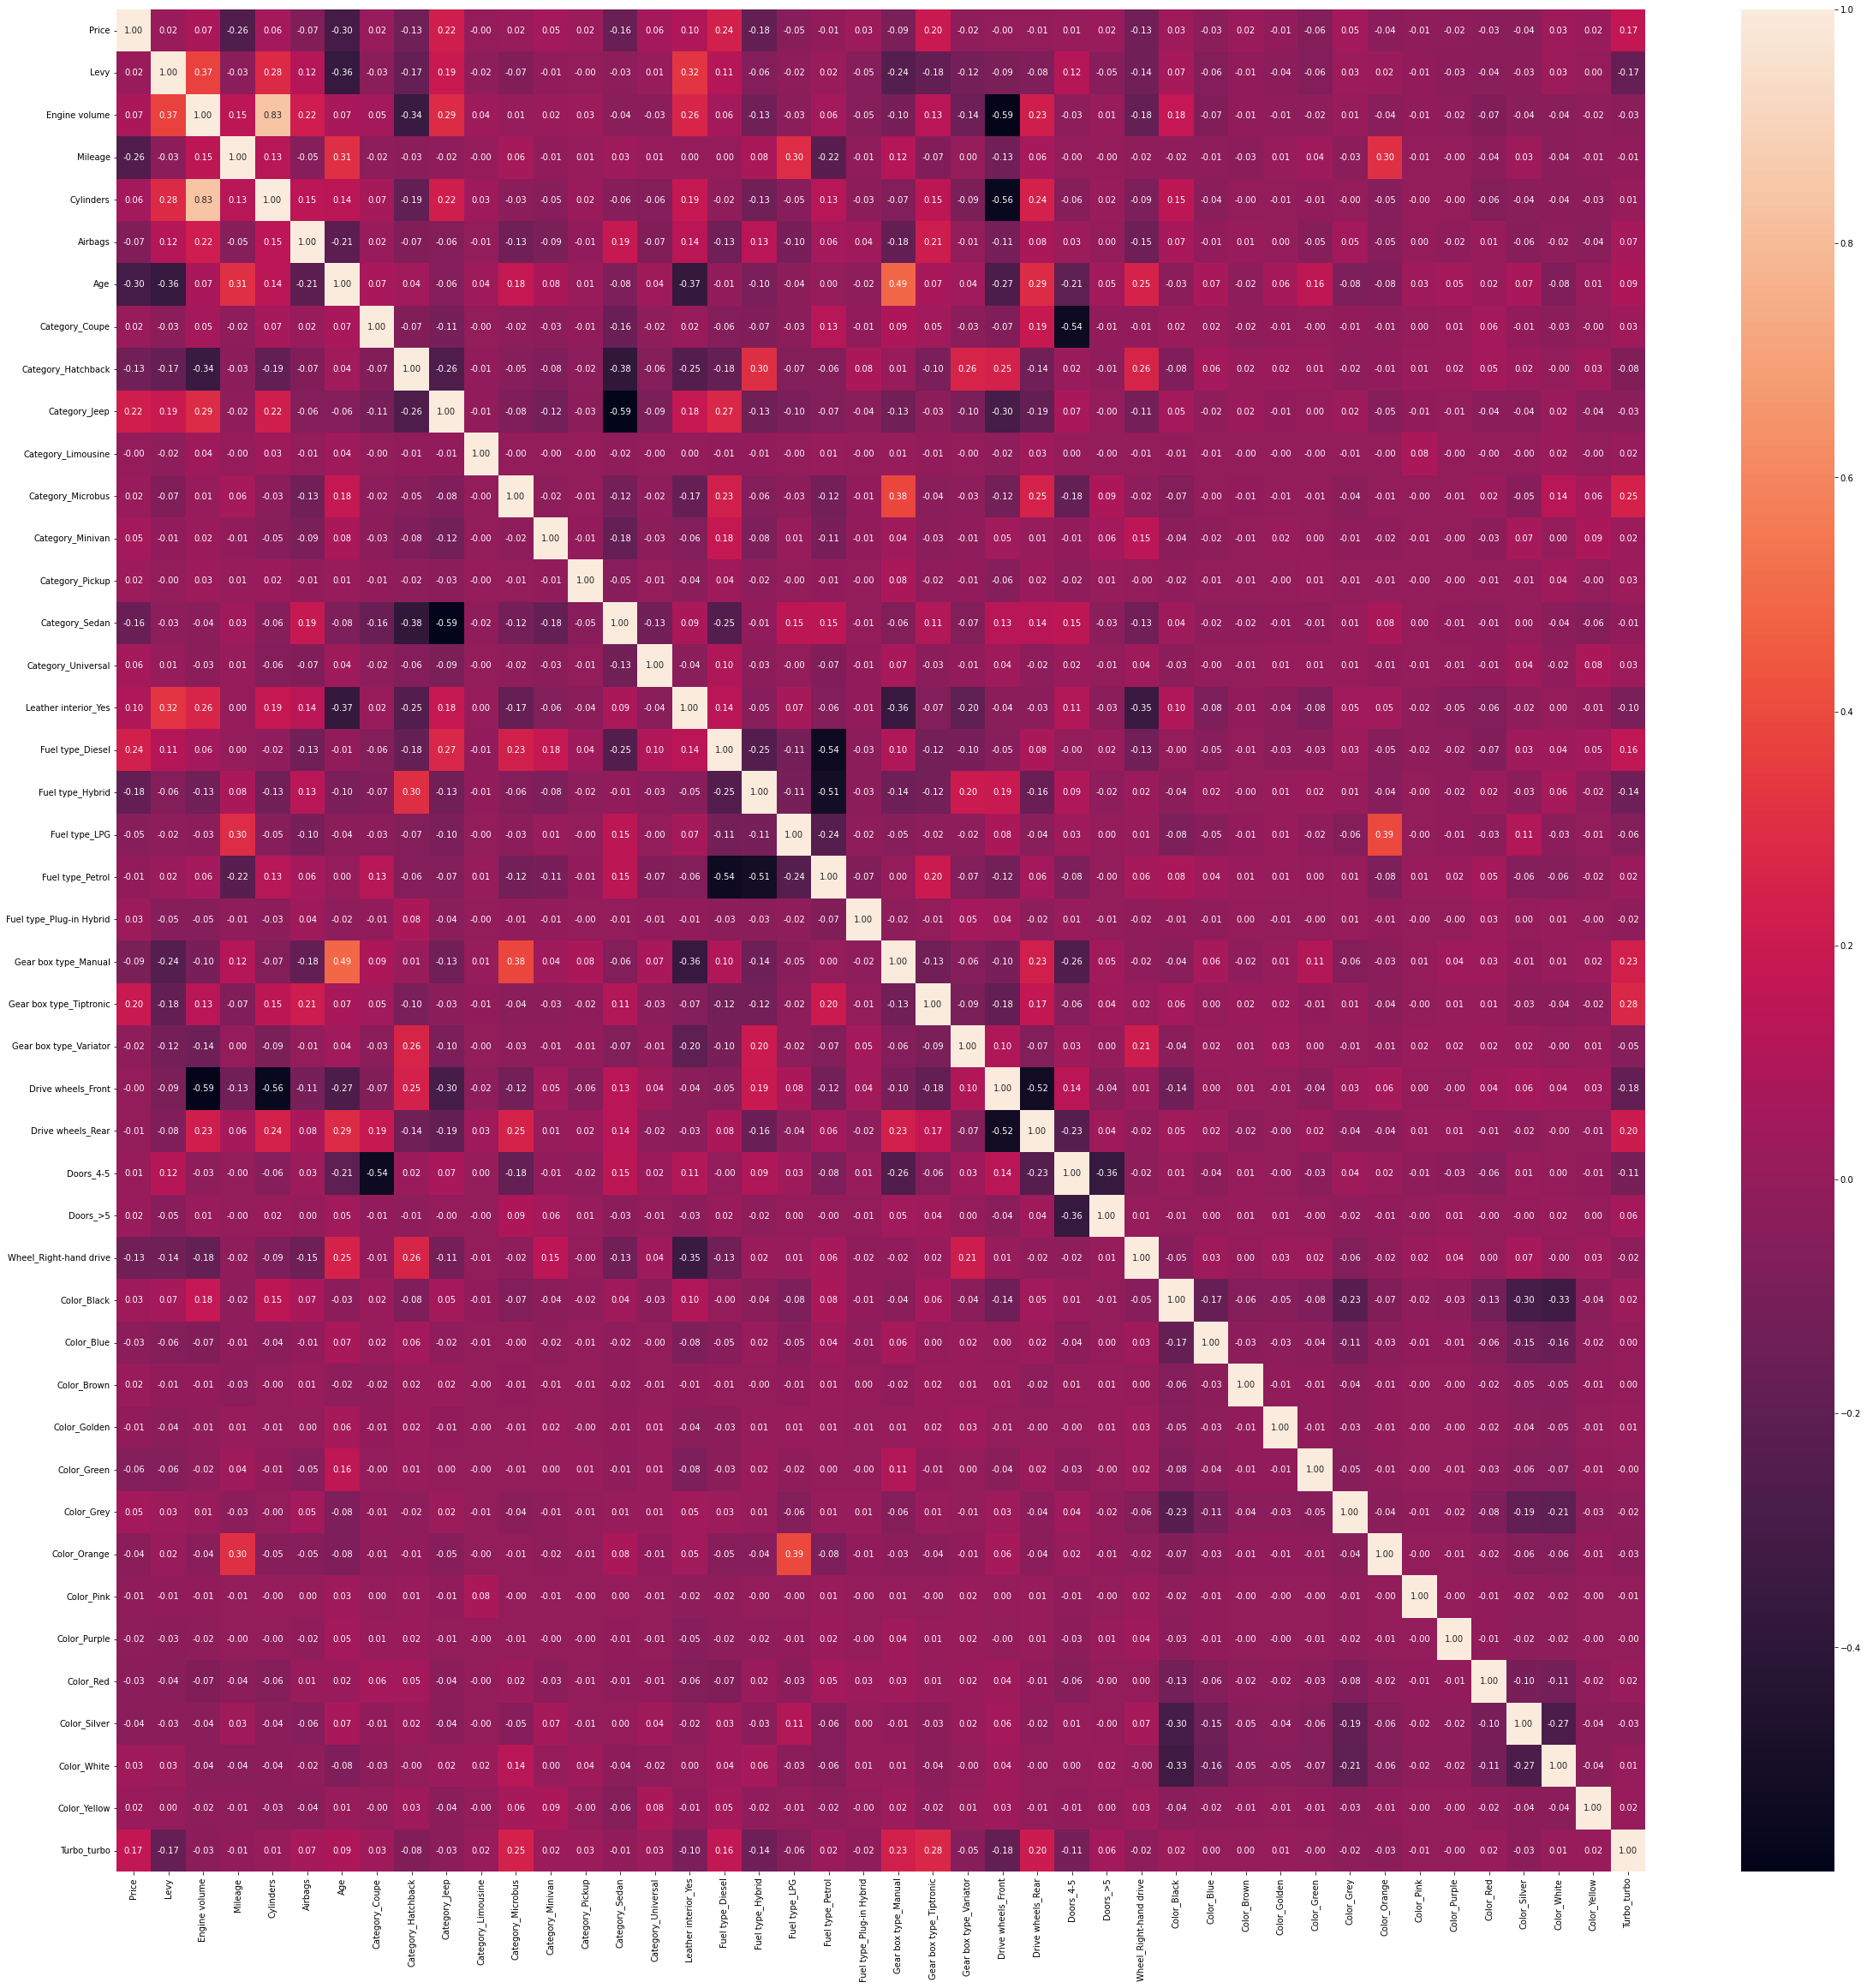

In [47]:
plt.subplots(figsize=(40,40))
sns.heatmap(df.corr(), annot=True, fmt=".2f");

In [48]:
# as can be seen from the matrix, not all features are uncorrelated to one-another, 
# e.g. Jeep and Diesel habe a relatively strong correlation (both of which have a strong correlation with price)

In [49]:
df.corr()['Price'].sort_values(key=abs, ascending=False)

Price                       1.000000
Age                        -0.304502
Mileage                    -0.256001
Fuel type_Diesel            0.241080
Category_Jeep               0.223801
Gear box type_Tiptronic     0.196240
Fuel type_Hybrid           -0.184340
Turbo_turbo                 0.171663
Category_Sedan             -0.162187
Wheel_Right-hand drive     -0.131522
Category_Hatchback         -0.126184
Leather interior_Yes        0.101604
Gear box type_Manual       -0.091699
Airbags                    -0.074794
Engine volume               0.074268
Category_Universal          0.059704
Color_Green                -0.057478
Cylinders                   0.056183
Category_Minivan            0.049364
Color_Grey                  0.048972
Fuel type_LPG              -0.045219
Color_Silver               -0.043566
Color_Orange               -0.035029
Color_Red                  -0.031097
Color_Blue                 -0.031025
Color_White                 0.030574
Color_Black                 0.030114
F

In [50]:
#0) create vectors and split dataset
X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#1) Instantiate
#lm_model = LinearRegression(normalize=True) 
lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

#2) Fit
lm_model.fit(X_train, y_train)

#3) Predict
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#4) Score
r2_test = r2_score(y_pred=y_test_preds, y_true=y_test)
r2_train = r2_score(y_pred=y_train_preds, y_true=y_train)

In [51]:
r2_train

0.35000459560838026

In [52]:
mean_squared_error(y_train,y_train_preds,squared=False)

11918.79481752863

<AxesSubplot:xlabel='Price'>

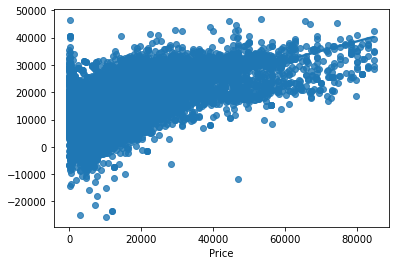

In [53]:
sns.regplot(x=y_train, y=y_train_preds)

In [54]:
r2_test

0.3355145991151176

In [55]:
mean_squared_error(y_test,y_test_preds,squared=False)

12193.782534761001

<AxesSubplot:xlabel='Price'>

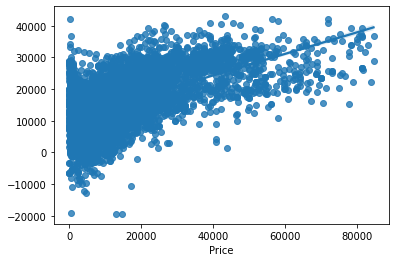

In [56]:
sns.regplot(x=y_test, y=y_test_preds)

In [57]:
y_test_preds.min()

-19417.326781405944

In [58]:
y_test_preds[y_test_preds < 0] = 0
#y_test_not_negative = y_test.iloc[,1]
y_test_preds.min()

0.0

In [59]:
mean_squared_error(y_test,y_test_preds,squared=False)

12126.393999819342

In [60]:
r2_score(y_pred=y_test_preds, y_true=y_test)

0.34283881759029355

## Evaluation

The dataset needed a lot of preprocessing and cleaning. For example, there were 'Goods wagons' in the dataset. There were issues with the format (mixing numbers and strings, dates instead of strings) but also with not plausible data, e.g. for cylinders, engine volumes, mileage.

It was established that fuel type has a major influence on used car prices, esp. for Diesel and LPG cars. Leather interiors do not make a difference in the first few years but can play a role for older cars. Colors are not really relevant, according to the dataset.

A linear model was set up. However, performance ist not particularly great. Both r2 score and mean squared error are not particularly promising. The model even predicts some negative prices. A bigger dataset could help to improve performance by allowing to incorporate manufacturer and model data without overfitting. Or more useful features such as the size of a car or the segment (luxury vs. entry), some of which are usually linked to the car model, would be useful.


By removing negative prices only a small improvement to the model scores is possible